In [15]:
import zipfile
import os
import json

zip_path = "/content/user-wallet-transactions.json.zip"  # <- your uploaded zip file path

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")
    print("✅ ZIP extracted")

# Find JSON inside extracted files
json_file = None
for filename in os.listdir("/content/"):
    if filename.endswith('.json'):
        json_file = os.path.join("/content/", filename)
        break

# Load JSON
with open(json_file, 'r') as f:
    data = json.load(f)

print(f"✅ Loaded {len(data)} wallets from {json_file}")


✅ ZIP extracted
✅ Loaded 100000 wallets from /content/user-wallet-transactions.json


In [16]:
# Check structure of a sample record
print(f"Type of top-level data: {type(data)}")
print(f"Total entries: {len(data)}")
print("First wallet entry sample:")
print(json.dumps(data[0], indent=2))  # show first record nicely formatted


Type of top-level data: <class 'list'>
Total entries: 100000
First wallet entry sample:
{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },
  "updatedAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  }
}


In [17]:
import pandas as pd

# Convert list of transactions to DataFrame
df = pd.DataFrame(data)

# Flatten nested 'actionData' fields
action_data = pd.json_normalize(df['actionData'])
df = pd.concat([df.drop(columns=['actionData']), action_data], axis=1)

# Preview
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,...,repayerId,liquidatorId,collateralAmount,collateralAssetPriceUSD,principalAmount,borrowAssetPriceUSD,collateralReserveId,collateralReserveSymbol,principalReserveId,principalReserveSymbol
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Convert amount and assetPriceUSD to float
df['amount'] = df['amount'].astype(float)
df['assetPriceUSD'] = df['assetPriceUSD'].astype(float)

# Calculate amount in USD
df['amountUSD'] = df['amount'] * df['assetPriceUSD'] / (10**6)  # USDC has 6 decimals

# Group by wallet
wallet_stats = df.groupby('userWallet').agg(
    total_txns = ('txHash', 'count'),
    total_usd = ('amountUSD', 'sum'),
    avg_usd = ('amountUSD', 'mean'),
    distinct_assets = ('assetSymbol', pd.Series.nunique),
    actions = ('type', lambda x: x.value_counts().to_dict())
).reset_index()

wallet_stats.head()


,userWallet,total_txns,total_usd,avg_usd,distinct_assets,actions
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,1.987664e+03,1,{'Deposit': 1}
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,2.856945e+14,1,{'Deposit': 1}
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,2.576155e+09,1,{'Deposit': 2}
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,9.803600e+14,5.766824e+13,4,{'RedeemUnderlying': 17}
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,3.797495e+17,9.517531e+14,6,"{'Deposit': 250, 'RedeemUnderlying': 130, 'Bor..."


In [19]:
# Extract all action types
from pandas import json_normalize

# Expand the action dictionary into columns
action_df = wallet_stats['actions'].apply(pd.Series).fillna(0).astype(int)

# Merge back into main dataframe
wallet_stats = pd.concat([wallet_stats.drop(columns=['actions']), action_df], axis=1)

wallet_stats.head()


,userWallet,total_txns,total_usd,avg_usd,distinct_assets,Deposit,RedeemUnderlying,Borrow,Repay,LiquidationCall
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,1.987664e+03,1,1,0,0,0,0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,2.856945e+14,1,1,0,0,0,0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,2.576155e+09,1,2,0,0,0,0
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,9.803600e+14,5.766824e+13,4,0,17,0,0,0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,3.797495e+17,9.517531e+14,6,250,130,15,4,0


In [20]:
# Example: Ratio of deposits to total txns
wallet_stats['deposit_ratio'] = wallet_stats['Deposit'] / wallet_stats['total_txns']

# Example: Activity score (you can scale as needed later)
wallet_stats['activity_score'] = (
    wallet_stats['total_usd'] * 0.5 +
    wallet_stats['avg_usd'] * 0.3 +
    wallet_stats['distinct_assets'] * 0.2
)

wallet_stats.head()


,userWallet,total_txns,total_usd,avg_usd,distinct_assets,Deposit,RedeemUnderlying,Borrow,Repay,LiquidationCall,deposit_ratio,activity_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,1.987664e+03,1,1,0,0,0,0,1.000000,1.590331e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,2.856945e+14,1,1,0,0,0,0,1.000000,2.285556e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,2.576155e+09,1,2,0,0,0,0,1.000000,3.349002e+09
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,9.803600e+14,5.766824e+13,4,0,17,0,0,0,0.000000,5.074805e+14
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,3.797495e+17,9.517531e+14,6,250,130,15,4,0,0.626566,1.901603e+17


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1000))
wallet_stats['credit_score'] = scaler.fit_transform(wallet_stats[['activity_score']])

# Final columns to keep
final_df = wallet_stats[['userWallet', 'credit_score'] + [col for col in wallet_stats.columns if col not in ['userWallet', 'credit_score']]]

final_df.sort_values('credit_score', ascending=False).head()


,userWallet,credit_score,total_txns,total_usd,avg_usd,distinct_assets,Deposit,RedeemUnderlying,Borrow,Repay,LiquidationCall,deposit_ratio,activity_score
137,0x0034baeeb160a5f1032b6d124d3e87cc94d74e62,1000.000000,162,1.912249e+20,1.180400e+18,2,59,37,45,21,0,0.364198,9.596655e+19
54,0x000f7f22bfc28d940d4b68e13213ab17cf107790,790.528642,73,1.504917e+20,2.061530e+18,5,26,15,19,13,0,0.356164,7.586431e+19
1299,0x022b3fa410364e1e28054b704b0da3b67aa6dc90,505.178272,47,9.573825e+19,2.036984e+18,1,17,9,14,7,0,0.361702,4.848022e+19
3178,0x058b10cbe1872ad139b00326686ee8ccef274c58,494.784956,522,9.485658e+19,1.817176e+17,7,257,138,100,27,0,0.492337,4.748281e+19
1733,0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6,315.014700,167,6.024530e+19,3.607503e+17,8,32,43,21,71,0,0.191617,3.023088e+19


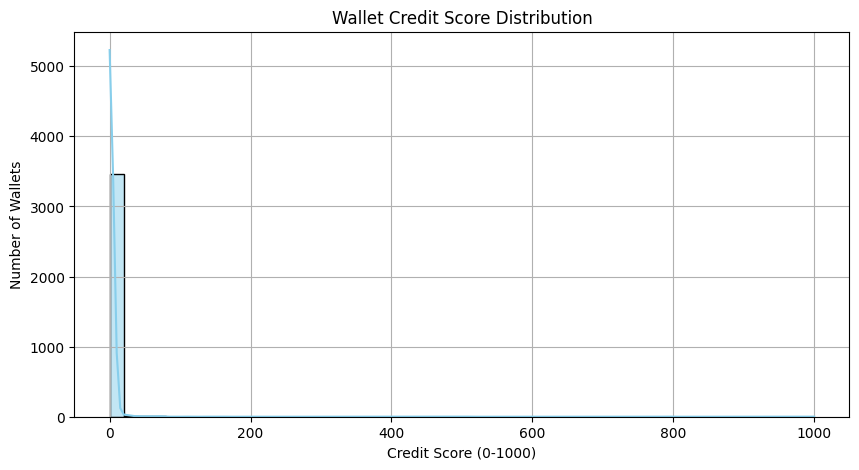

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(wallet_stats['credit_score'], bins=50, kde=True, color="skyblue")
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score (0-1000)")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


In [24]:
# Save to CSV
wallet_stats.to_csv("/content/wallet_credit_scores.csv", index=False)
print("✅ Saved: /content/wallet_credit_scores.csv")


✅ Saved: /content/wallet_credit_scores.csv


In [25]:
# Group wallets by credit score ranges
wallet_stats['score_group'] = pd.cut(wallet_stats['credit_score'],
                                      bins=[0, 200, 400, 600, 800, 1000],
                                      labels=["Very Low", "Low", "Medium", "High", "Very High"])

group_summary = wallet_stats.groupby('score_group').agg({
    'userWallet': 'count',
    'total_txns': 'mean',
    'total_usd': 'mean',
    'distinct_assets': 'mean'
}).rename(columns={'userWallet': 'wallet_count'})

print(group_summary)


             wallet_count  total_txns     total_usd  distinct_assets
score_group                                                         
Very Low             3490   28.349284  1.498698e+17          2.45043
Low                     2  128.000000  5.587827e+19          5.00000
Medium                  2  284.500000  9.529741e+19          4.00000
High                    1   73.000000  1.504917e+20          5.00000
Very High               1  162.000000  1.912249e+20          2.00000


/tmp/ipython-input-25-945786329.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = wallet_stats.groupby('score_group').agg({
